In [1]:
# si utilisé dans jupyter utiliser la ligne suivante, si utilisé dans VisualStudioCode utiliser la seconde
#%matplotlib widget
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import os

nb_points:int = 11
gr_bounds:list[int] = [0, 8]
ws_bounds:list[int] = [0, 1]
pb_bounds:list[int] = [0, 1]
gr_episilon:float = (gr_bounds[1]-gr_bounds[0])/(nb_points-1)
ws_episilon:float = (ws_bounds[1]-ws_bounds[0])/(nb_points-1)
pb_episilon:float = (pb_bounds[1]-pb_bounds[0])/(nb_points-1)

In [2]:
# \Dessiner la figure en 3D pour la partie de recherche des paramètres
def dessin3D(data, missionName:str=""): # type: ignore
    plt.figure(missionName) # type: ignore
    axes = plt.axes(projection='3d') # type: ignore
    list_ok_gr:list[float] = []
    list_ok_pb:list[float] = []
    list_ok_ws:list[float] = []
    list_ko_gr:list[float] = []
    list_ko_pb:list[float] = []
    list_ko_ws:list[float] = []
    list_over_gr:list[float] = []
    list_over_pb:list[float] = []
    list_over_ws:list[float] = []
    for i in range(len(data)): # type: ignore
        gr:float = round(i*gr_episilon,2)
        for j in range(len(data[i])): # type: ignore
            ws:float = round(j*ws_episilon,2)
            for k in range(len(data[i][j])): # type: ignore
                pb:float = round(k*pb_episilon,2)
                v:int = int(data[i,j,k]) # type: ignore
                if(v==1):
                    list_ok_gr.append(gr)
                    list_ok_ws.append(ws)
                    list_ok_pb.append(pb)
                elif(v==2):
                    list_ko_gr.append(gr)
                    list_ko_ws.append(ws)
                    list_ko_pb.append(pb)
                elif(v==-1):
                    list_over_gr.append(gr)
                    list_over_ws.append(ws)
                    list_over_pb.append(pb)
    axes.scatter3D(list_ok_gr,list_ok_ws,list_ok_pb, c='green', marker='.', label="Found") # type: ignore
    #Commenter la ligne suivante pour ne pas afficher les points rouges
    #axes.scatter3D(list_ko_gr,list_ko_ws,list_ko_pb, c='red', marker='.', label="Not found") # type: ignore
    #Commenter la ligne suivante pour ne pas afficher les points noirs
    axes.scatter3D(list_over_gr,list_over_ws,list_over_pb, c='black', marker='.', label="Over time") # type: ignore
    axes.set_xlabel('gr') # type: ignore
    axes.set_ylabel('ws') # type: ignore
    axes.set_zlabel('pb') # type: ignore
    axes.set_xlim([0, 8]) # type: ignore
    axes.set_ylim([0, 1]) # type: ignore
    axes.set_zlim([0, 1]) # type: ignore
    plt.legend(loc="upper right") # type: ignore
    plt.title(missionName,fontsize=20) # type: ignore
    plt.show() # type: ignore

In [3]:
# \Dessine pour chaque combinaison de paramètre un point dont la taille est proportionnelle au nombre fois que ce jeu de paramètre permet de trouver la solution attendue
def dessinPerf(fileList:list[str], mainDir:str):
    plt.figure("Perf") # type: ignore
    axes = plt.axes(projection='3d') # type: ignore

    # La matrice qui va contenir pour chaque triplet de paramètre sa performance (le nombre de fois qu'il permet de trouver une solution)
    parametersPerformance:list[list[list[list[str]]]] = []
    # Parcourir tous les cas et comptabiliser les performances
    max:int = 0
    for n in range(len(fileList)):
        targetFileName:str = fileList[n]
        file:str = mainDir+"/files_npy/filled_"+targetFileName+".npy"
        data = np.load(file)
        # Si la matrice de performance n'est pas initialisée, la définir de la même taille que les data de cette première analyse
        if (len(parametersPerformance) == 0):
            for plan in data:
                parametersPerformance.append([])
                for line in plan:
                    parametersPerformance[-1].append([])
                    for _ in line:
                        parametersPerformance[-1][-1].append([])
        testNumber:str = targetFileName.split("_")[0]
        # Parcourir tous les gr du cas en cours
        for i in range(len(data)):
            # Parcourir tous les ws du cas en cours
            for j in range(len(data[i])):
                # Parcourir tous les pb du cas en cours
                for k in range(len(data[i][j])):
                    v = int(data[i,j,k])
                    if (v==1):
                        # On ajoute pour ce point là le numéro du test pour ce noter qu'il a été positif pour ce test
                        parametersPerformance[i][j][k].append(testNumber)
                        # Si la longueur de la liste est plus grande que le max, on le met à jour
                        if (len(parametersPerformance[i][j][k]) > max):
                            max = len(parametersPerformance[i][j][k])
                    ## Si les paramètres i, j et k ont été évalués positivement OU qu'ils n'ont pas été évalué mais que sont voisinnage l'a été (il faut regarder k-1 (en dessous), j-1 (à gauche) et i-1 (en arrière)), on note ces paramètres comme positif, si non on le note comme négatif
                    #if (v==1 or (v==0 and (k-1 > 0 and int(data[i,j,k-1]) == 1) or (j-1 > 0 and int(data[i,j-1,k]) == 1) or (i-1 > 0 and int(data[i-1,j,k]) == 1))):
                    #    data[i,j,k] = 1
                    #    # On ajoute pour ce point là le numéro du test pour se noter qu'il a été positif pour ce test
                    #    parametersPerformance[i][j][k].append(targetFileName.split("_")[0])
                    #    # Si la longueur de la liste est plus grande que le max, on le met à jour
                    #    if (len(parametersPerformance[i][j][k]) > max):
                    #        max = len(parametersPerformance[i][j][k])
    print(max)
    
    # Créer les vecteurs X, Y, Z, et Size
    vec_X:list[float] = []
    vec_Y:list[float] = []
    vec_Z:list[float] = []
    vec_Size:list[int] = []
    # Parcourir tous les gr du cas en cours
    for i in range(len(data)): # type: ignore
        gr:float = round(i*gr_episilon,2)
        # Parcourir tous les ws du cas en cours
        for j in range(len(data[i])): # type: ignore
            ws:float = round(j*ws_episilon,2)
            # Parcourir tous les pb du cas en cours
            for k in range(len(data[i][j])): # type: ignore
                if (len(parametersPerformance[i][j][k])/len(fileList) >= 0.76):
                    pb:float = round(k*pb_episilon,2)
                    print ("gr: ", gr, ", ws: ", ws, ", pb: ", pb, " => ", len(parametersPerformance[i][j][k])/len(fileList))
                    vec_X.append(gr)
                    vec_Y.append(ws)
                    vec_Z.append(pb)
                    vec_Size.append(len(parametersPerformance[i][j][k])**2)

    axes.scatter3D(vec_X,vec_Y,vec_Z,s=vec_Size, c='green', marker='.') # type: ignore
    axes.set_xlabel('gr') # type: ignore
    axes.set_ylabel('ws') # type: ignore
    axes.set_zlabel('pb') # type: ignore
    axes.set_xlim(gr_bounds) # type: ignore
    axes.set_ylim(ws_bounds) # type: ignore
    axes.set_zlim(pb_bounds) # type: ignore
    plt.title("Performance",fontsize=20) # type: ignore
    plt.show() # type: ignore

In [4]:
# Fonction d'aide pour construire la liste des fichiers à explorer
def defineTestIfEmpty(testList:list[str], dir:str):
    if testList == []:
        if not os.path.isdir(dir):
            print("Error: "+dir+" is not a directory")
            raise
        if not os.path.isdir(dir+"/example") or not os.path.isdir(dir+"/example/solutions"):
            print("Error: "+dir+" is not correctly structured. It must contain these sub directories: "+dir+"/example/solutions/")
            raise
        testList=[f.replace('.log', '') for f in os.listdir(dir+"/example") if f.endswith(".log")]
    return testList

Chaque point représente une compression, si le point est vert cela signifie que les paramètres (gs, gr et pb) ont permis de construire la solution recherchée, si le point est rouge cela signifie que les paramètres ont permis une construire une solution différente de la solution recherchée, si le point est noir cela signifie que ce jeu de paramètres n'a pas permis de construire une solution dans le temps imparti


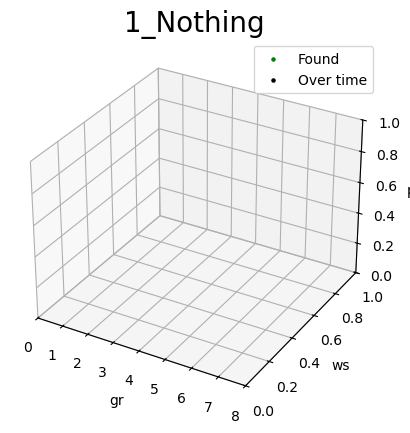

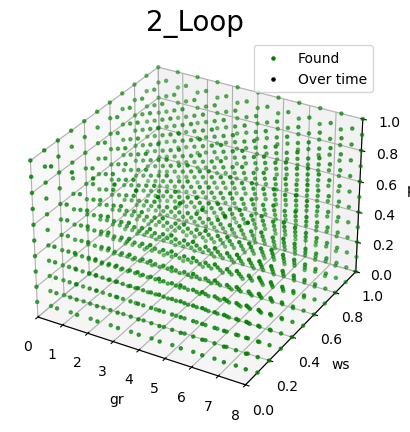

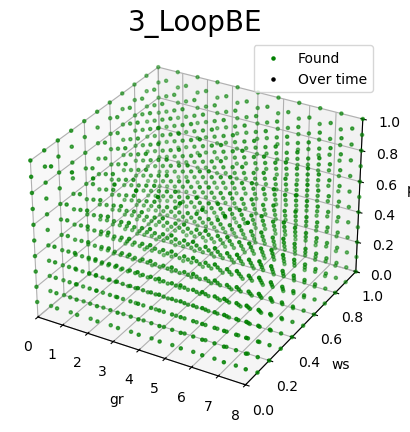

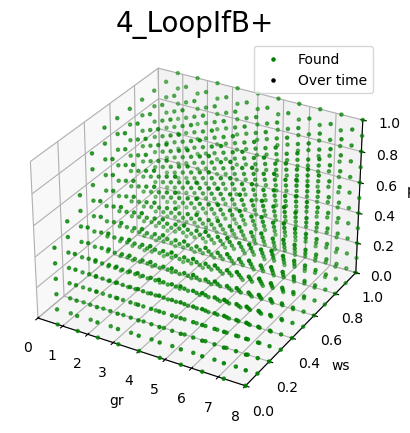

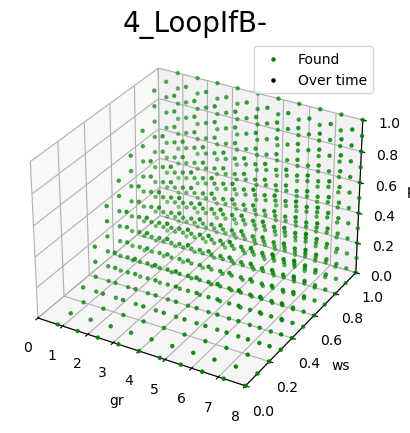

In [ ]:



print("Chaque point représente une compression, si le point est vert cela signifie que les paramètres (gs, gr et pb) ont permis de construire la solution recherchée, si le point est rouge cela signifie que les paramètres ont permis une construire une solution différente de la solution recherchée, si le point est noir cela signifie que ce jeu de paramètres n'a pas permis de construire une solution dans le temps imparti")
#tests:list[str] = ["m1", "m2", "m3", "m4", "m5", "m6", "m7", "m81", "m82", "m83", "m11"]
#mainDir:str = "./dataset1"

#tests:list[str] = ["1_rienAFaire", "2_simpleBoucle", "3_simpleBoucleAvecDebut", "4_simpleBoucleAvecFin", "5_simpleBoucleAvecDebutEtFin", "6.01_simpleBoucleAvecIf", "6.02_simpleBoucleAvecIf", "6.03_simpleBoucleAvecIf", "6.04_simpleBoucleAvecIf", "6.05_simpleBoucleAvecIf", "6.06_simpleBoucleAvecIf", "6.07_simpleBoucleAvecIf", "6.08_simpleBoucleAvecIf", "6.09_simpleBoucleAvecIf", "6.10_simpleBoucleAvecIf", "6.11_simpleBoucleAvecIf", "6.12_simpleBoucleAvecIf", "6.13_simpleBoucleAvecIf", "6.14_simpleBoucleAvecIf", "6.15_simpleBoucleAvecIf", "7.01_bouclesEnSequence", "7.02_bouclesEnSequence", "8_bouclesEnSequenceAvecIf", "9.01_bouclesImbriquees", "9.02_bouclesImbriquees", "9.03_bouclesImbriquees"]
#tests:list[str] = ["6.04_simpleBoucleAvecIf"]
#mainDir:str = "./dataset2"

#tests:list[str] = ["1_Nothing", "2_Loop", "3_LoopBE", "4_LoopIfB-", "4_LoopIfB+", "4_LoopIfE-", "4_LoopIfE+", "4_LoopIfM-", "4_LoopIfM+", "5_LoopsSeq", "5_LoopsSeq2", "5_LoopsSeq3", "6_LoopSeqIf1", "6_LoopSeqIf2", "6_LoopSeqIf3", "7_NestedLoop", "7_NestedLoop2", "7_NestedLoop2", "7_NestedLoopIf1", "7_NestedLoopIf2", "7_NestedLoopIf3", "7_NestedLoopIf4"]
#tests:list[str] = ["7_NestedLoopIf3", "7_NestedLoopIf4"]
#mainDir:str = "./dataset3"

tests:list[str] = []
mainDir:str = "./datasetXP"

version:str = "dichotomous"
#version:str = "exhaustive"

tests = defineTestIfEmpty(tests, mainDir)

for test in tests:
    file:str = mainDir+"/files_npy/"+version+"_"+test+".npy"
    data = np.load(file)
    dessin3D(data, missionName=test)

In [14]:
#Ferme les figure précédemment ouvertes
for test in tests:
    plt.close(test)

In [5]:
def computeLength(compressionStats:dict[str, str]) -> int:
    content:str = compressionStats["Compression"]
    # len(content) : donne la longeur de la chaine entière
    # content.count('*')*2+int(compressionStats["OptCount"]) : compte le nombre d'options en évitant de compter en double le cas des [A*BCDA*] où A* ne compte que pour une seule option qui peut être soit au début soit à la fin. Donc on compte le nombre d'étoile que l'on multiplie par deux pour compter aussi sont Event associé puis on rajoute le décompte d'options des statistiques de la compression
    # content.count(']') compte le nombre de fin de séquence pour ne prendre en compte que les début de séquence
    return len(content)-content.count('*')*2+int(compressionStats["OptCount"])-content.count(']')

def computeScore(compressionStats:dict[str, str], lmax:int) -> float:
    length:int = computeLength(compressionStats)
    # 70% de score repose sur la longueur et 30% sur les options
    optWeight:float = 0.3
    # 1-length/lmax favorise les séquences courtes
    # 1-int(compressionStats["OptCount"])/length favorise les séquences avec peu d'éléments optionnels
    return (1-optWeight)*(1-length/lmax)+optWeight*(1-int(compressionStats["OptCount"])/length)

In [6]:
#tests:list[str] = ["m1", "m2", "m3", "m4", "m5", "m6", "m7", "m81", "m82", "m83", "m11"]
#tests:list[str] = ["m82"]
#mainDir:str = "./dataset1"

#tests:list[str] = ["1_rienAFaire", "2_simpleBoucle", "3_simpleBoucleAvecDebut", "4_simpleBoucleAvecFin", "5_simpleBoucleAvecDebutEtFin", "6.01_simpleBoucleAvecIf", "6.02_simpleBoucleAvecIf", "6.03_simpleBoucleAvecIf", "6.04_simpleBoucleAvecIf", "6.05_simpleBoucleAvecIf", "6.06_simpleBoucleAvecIf", "6.07_simpleBoucleAvecIf", "6.08_simpleBoucleAvecIf", "6.09_simpleBoucleAvecIf", "6.10_simpleBoucleAvecIf", "6.11_simpleBoucleAvecIf", "6.12_simpleBoucleAvecIf", "6.13_simpleBoucleAvecIf", "6.14_simpleBoucleAvecIf", "6.15_simpleBoucleAvecIf", "7.01_bouclesEnSequence", "7.02_bouclesEnSequence", "8_bouclesEnSequenceAvecIf", "9.01_bouclesImbriquees", "9.02_bouclesImbriquees", "9.03_bouclesImbriquees"]
#tests:list[str] = ["8_bouclesEnSequenceAvecIf"]
#mainDir:str = "./dataset2"


#tests:list[str] = ["1_Nothing", "2_Loop", "3_LoopBE", "4_LoopIfB-", "4_LoopIfB+", "4_LoopIfE-", "4_LoopIfE+", "4_LoopIfM-", "4_LoopIfM+", "5_LoopsSeq", "5_LoopsSeq2", "5_LoopsSeq3", "6_LoopSeqIf1", "6_LoopSeqIf2", "6_LoopSeqIf3", "7_NestedLoop", "7_NestedLoop2", "7_NestedLoopIf1", "7_NestedLoopIf2", "7_NestedLoopIf3", "7_NestedLoopIf4"]
#tests:list[str] = ["7_NestedLoopIf3", "7_NestedLoopIf4"]
#mainDir:str = "./dataset3"

tests:list[str] = []
mainDir:str = "./datasetXP"

version:str = "dichotomous"
#version:str = "exhaustive"

tests = defineTestIfEmpty(tests, mainDir)

# Calcul des performance uniquement pour datasetXP
if "datasetXP" in mainDir:
    #identifier le nombre de scénario
    maxNb = 0
    for example_filename in os.listdir(mainDir+"/example"):
        if example_filename.endswith(".log"):
            scenarNum = int(example_filename.split('_')[0])
            if scenarNum > maxNb:
                maxNb = scenarNum
    correct_counts = [0]*maxNb

# Parcourir tout le jeu de test
for test in tests:
    data:dict[str, list[dict[str, str]]]
    # Ouvrir le fichier JSON et le charger dans un dictionnaire
    with open(mainDir+"/solutionsExplored/"+version+"_"+test+".txt", 'r', encoding='utf-8') as fichier:
        data = json.load(fichier)
    
    #Ouvrir la solution optimale
    solution:str = ""
    with open(mainDir+"/example/solutions/"+test+".log", 'r', encoding='utf-8') as fichier:
        solution = fichier.read()

    # Recherche des maxima
    maxLen:int = 0
    shortLen:int = -1
    maxAlign:int = 0
    maxOpt:int = 0
    maxMerge:int = 0
    for k,stats in data.items():
        for stat in stats:
            # Vérifier si on n'est pas dans le cas de l'OverTime (Tout égal à 0)
            if stat["AlignCount"] == "0" and stat["OptCount"] == "0" and stat["MergeCount"] == "0" :
                continue
            length:int = computeLength(stat)
            if length > maxLen:
                maxLen = length
            if length < shortLen or shortLen == -1:
                shortLen = length
            if int(stat["AlignCount"]) > maxAlign:
                maxAlign = int(stat["AlignCount"])
            if int(stat["OptCount"]) > maxOpt:
                maxOpt = int(stat["OptCount"])
            if int(stat["MergeCount"]) > maxMerge:
                maxMerge = int(stat["MergeCount"])
    
    ## Calcul du score max
    maxScore:float = 0
    for k,stats in data.items():
        for stat in stats:
            # Vérifier qu'on a au moins une stat (pas le cas de l'OverTime)
            if stat["AlignCount"] != "0" or stat["OptCount"] != "0" or stat["MergeCount"] != "0" :
                currentScore:float = computeScore(stat, maxLen)
                if currentScore > maxScore :
                    maxScore = currentScore
    
    print ("Meilleur score de \""+test+"\" : maxScore="+str(maxScore)+"; shortLen="+str(shortLen)+"; maxLen="+str(maxLen)+"; maxAlign="+str(maxAlign)+"; maxOpt="+str(maxOpt)+"; maxMerge="+str(maxMerge))
    # Affichage des meilleurs solutions
    bestSol:dict[str, int] = {}
    popularSol:dict[str, int] = {}
    countMaxScore:int = 0
    countCompression:int = 0
    for k,stats in data.items():
        for stat in stats:
            if computeScore(stat, maxLen) == maxScore:
                if stat["Compression"] in bestSol:
                    bestSol[stat["Compression"]] += 1
                else:
                    bestSol[stat["Compression"]] = 1
                countMaxScore += 1
            if stat["Compression"] in popularSol:
                popularSol[stat["Compression"]] += 1
            else:
                popularSol[stat["Compression"]] = 1
            countCompression += 1
    print("Meilleures solutions (meilleur score) :")

    for k,v in bestSol.items():
        print(("\033[92m"+k+"\033[0m" if k==solution else k)+": "+str(v)+" ("+str(int(v/countMaxScore*100))+"%)")
        # on ne comptabilise la performance que pour datasetXP
        if k == solution and "datasetXP" in mainDir:
            correct_counts[int(test.split("_")[0])-1] += 1


    # Transformation de popularSol en liste de tuple (Compression, Score)
    popularSolList:list[tuple[str, int]] = []
    for k,v in popularSol.items():
        popularSolList.append((k, v))
    # Trie de popularSolList par ordre décroissant
    popularSolList.sort(key=lambda x: x[1], reverse=True)
    # Affichage des 3 premières solutions les plus populaires
    print("Les 3 solutions les plus populaires :")
    bestSolFound:bool = False
    for compression,counter in popularSolList[:3]:
        # calcul du score de cette solution
        score:float = 0
        for k,stats in data.items():
            for stat in stats:
                if stat["Compression"] == compression:
                    score = computeScore(stat, maxLen)
                    if compression == solution:
                        bestSolFound = True
                    break
            if score > 0:
                break
        print(("\033[92m"+compression+"\033[0m" if compression==solution else compression)+": "+str(counter)+" ("+str(int(counter/countCompression*100))+"%) score="+str(score))
    if len(popularSolList) > 3:
        print("...")
    if not bestSolFound:
        # Recherche de la position de la solution optimale dans la liste des solutions
        for i,compression in enumerate(popularSolList):
            if compression[0] == solution:
                 # calcul du score de cette solution
                score:float = 0
                for k,stats in data.items():
                    for stat in stats:
                        if stat["Compression"] == compression[0]:
                            score = computeScore(stat, maxLen)
                            break
                    if score > 0:
                        break

                print("["+str(i)+"] \033[92m"+compression[0]+"\033[0m: "+str(compression[1])+" ("+str(int(compression[1]/countCompression*100))+"%) score="+str(score))
                print("...")
                break
    print("--------------------------------")
    #output:str = ""
    #bestSol:dict[str, int] = {}
    #for k,stats in data.items():
    #    for stat in stats:
    #        output += k+": "+stat["Compression"]+" score="+str(computeScore(stat, maxLen))+"; len="+str(computeLength(stat))+"; align="+stat["AlignCount"]+"; opt="+stat["OptCount"]+"; merge="+stat["MergeCount"]+"\n"
    # Afficher le dictionnaire
    #print(output)

# Affichage des performance uniquement pour datasetXP
if "datasetXP" in mainDir:
    print(correct_counts)

Meilleur score de "10_10_" : maxScore=0.813; shortLen=4; maxLen=25; maxAlign=54; maxOpt=14; maxMerge=31
Meilleures solutions (meilleur score) :
[U*VIU*]: 208 (100%)
Les 3 solutions les plus populaires :
[U*VIU*]: 208 (27%) score=0.813
UV[IU*V]I: 87 (11%) score=0.7611428571428571
U[V*I*VIUV*I*]: 60 (7%) score=0.7182857142857143
...
--------------------------------
Meilleur score de "10_1_" : maxScore=0.3; shortLen=4; maxLen=4; maxAlign=6; maxOpt=2; maxMerge=3
Meilleures solutions (meilleur score) :
[UWE]: 27 (100%)
Les 3 solutions les plus populaires :
[UWE]: 27 (31%) score=0.3
[W*E*UW*E*]: 10 (11%) score=0.15
[U*WEU*]: 10 (11%) score=0.22499999999999998
...
--------------------------------
Meilleur score de "10_2_" : maxScore=0.8374999999999999; shortLen=4; maxLen=32; maxAlign=52; maxOpt=14; maxMerge=31
Meilleures solutions (meilleur score) :
[Q*PRQ*]: 202 (100%)
Les 3 solutions les plus populaires :
[Q*PRQ*]: 202 (18%) score=0.8374999999999999
QPR[PRQ]PRPR: 103 (9%) score=0.7593749999

In [ ]:
#files:list[str] = ["1_rienAFaire", "2_simpleBoucle", "3_simpleBoucleAvecDebut", "4_simpleBoucleAvecFin", "5_simpleBoucleAvecDebutEtFin", "6.01_simpleBoucleAvecIf", "6.02_simpleBoucleAvecIf", "6.03_simpleBoucleAvecIf", "6.04_simpleBoucleAvecIf", "6.05_simpleBoucleAvecIf", "6.06_simpleBoucleAvecIf", "6.07_simpleBoucleAvecIf", "6.08_simpleBoucleAvecIf", "6.09_simpleBoucleAvecIf", "6.10_simpleBoucleAvecIf", "6.11_simpleBoucleAvecIf", "6.12_simpleBoucleAvecIf", "6.13_simpleBoucleAvecIf", "6.14_simpleBoucleAvecIf", "7.01_bouclesEnSequence", "7.02_bouclesEnSequence", "8_bouclesEnSequenceAvecIf", "9.01_bouclesImbriquees", "9.02_bouclesImbriquees", "9.03_bouclesImbriquees"]
#files = ["m1", "m2", "m3", "m4", "m5", "m6", "m7", "m8", "m11","m81", "m82"]
#files = ["7.02_bouclesEnSequence"]

tests:list[str] = []
mainDir:str = "./datasetXP"

tests = defineTestIfEmpty(tests, mainDir)

print("Analyse de la performance des paramètres\n")
print("La taille de chaque point représente sa performance, plus le point est gros plus cette combinaison de paramètre aura permis de trouver la meilleure solution dans les différents cas")
dessinPerf(tests, mainDir) # type: ignore
    

Analyse de la performance des paramètres

La taille de chaque point représente sa performance, plus le point est gros plus cette combinaison de paramètre aura permis de trouver la meilleure solution dans les différents cas


TypeError: dessinPerf() missing 1 required positional argument: 'mainDir'